
# VGG19 
- model trainable = True  
- 데이터셋으로 직접 학습
- GlobalAveragePooling2D()
- 입력 데이터 사이즈 (224,224,3)
- optimizer = "rmsprop",
- 과적합 방지를 위해 earlystopping 적용
- 향상된 모델 저장 적용
- steps_per_epoch = 100
- epochs = 50

In [ ]:

import os
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.callbacks import EarlyStopping, ModelCheckpoint
from PIL import Image
from glob import glob
from google.colab import drive
from keras.applications.vgg19 import VGG19
import random
import cv2
import matplotlib.gridspec as gridspec
from tensorflow.keras.optimizers import Adam  #설정해줘야함
from keras.layers import Dense , GlobalAveragePooling2D

# https://www.kaggle.com/code/senolcomert/fruits-360-transfer-learning-vgg16/notebook

In [ ]:
# test_path = '/content/drive/MyDrive/안봐도보이조_project/resize_valid_(256,256)'
# train_path = '/content/drive/MyDrive/안봐도보이조_project/resize_train_(256,256)'

In [ ]:
valid_path = '/content/drive/MyDrive/안봐도보이조_project/valid_10'
train_path = '/content/drive/MyDrive/안봐도보이조_project/train_10'
test_path = '/content/drive/MyDrive/안봐도보이조_project/test_10'

In [ ]:
#Finding number of classes
className = glob((train_path) + '/*')
number_of_class = len(className)
print(number_of_class)

0


In [ ]:
labels=pd.Series(os.listdir(train_path))

labels=labels.sort_values()
labels=labels.to_list()
labels

['갈아만든배',
 '레쓰비',
 '마운틴듀',
 '밀키스',
 '스프라이트',
 '칠성사이다',
 '코카콜라',
 '트로피카나망고',
 '펩시콜라',
 '환타오렌지']

In [ ]:
numberOfClass = len(glob(train_path + "/*"))
numberOfClass

10

In [ ]:
#num of train images
len(glob(train_path + "/*/*"))

10529

#modeling


In [ ]:
vgg = VGG19(include_top = False)
vgg.trainable = True    # 가지고 있는 데이터로 학습 가능 true 설정
vgg.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [ ]:
from keras.layers import Dense , GlobalAveragePooling2D

global_average_layer = GlobalAveragePooling2D()

model = Sequential([
  vgg,
  global_average_layer,
  Flatten(),
  Dense(4096,activation="relu"),
  Dense(4096,activation="relu"),
  Dense(numberOfClass, activation="softmax")
])


In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 4096)              2101248   
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 dense_2 (Dense)             (None, 10)                40970     
                                                        

In [ ]:
model.compile(optimizer = "rmsprop",
              loss = 'categorical_crossentropy', # 손실함수 범주형 교차엔트로피 사용
              metrics = ['accuracy']) # 지표는 정확도

In [ ]:
# 데이터셋 준비
train_datagen = ImageDataGenerator(rescale=1./255,         # 픽셀 값을 0~1 범위로 변환(scaling)
                                   rotation_range=40,      # 40도까지 회전
                                   width_shift_range=0.2,  # 20%까지 좌우 이동
                                   height_shift_range=0.2, # 20%까지 상하 이동
                                   shear_range=0.2,        # 20%까지 기울임
                                   zoom_range=0.2,         # 20%까지 확대/축소
                                   vertical_flip=True)   # 위아래 뒤집기
    
train_data = train_datagen.flow_from_directory(train_path, # 데이터가 존재하는 디렉토리
                                                    # batch_size=100, # 배치사이즈(변경가능)
                                                    class_mode='categorical', # 다중 분류이므로 categorical
                                                    target_size=(224,224)) # 모델에 입력해줄 데이터 사이즈(변경가능)

valid_datagen = ImageDataGenerator(rescale=1./255) # 스케일링만 진행
valid_data = valid_datagen.flow_from_directory(valid_path,
                                              # batch_size=20,      
                                              class_mode='categorical', 
                                              target_size=(224, 224))

test_datagen = ImageDataGenerator(rescale=1./255) # 스케일링만 진행
test_data = test_datagen.flow_from_directory(test_path,
                                                  # batch_size=10,      
                                                  class_mode='categorical', 
                                                  target_size=(224, 224),shuffle=False, #test data 에선  shuffle false 로 해야
                                                 save_to_dir='./test_image', save_prefix='test', save_format='jpg')

Found 10529 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


In [ ]:
#모델 최적화 설정
MODEL_DIR = '/content/drive/MyDrive/model_sek/' #model dir 만들기
if not os.path.exists(MODEL_DIR):
  os.mkdir(MODEL_DIR)

modelpath = '/content/drive/MyDrive/model_sek/{epoch:02d}-{val_accuracy:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath = modelpath, monitor = 'val_loss', verbose = 1, save_best_only = True)
 #valloss 기준으로 좋아지는 모델 저장
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10)
 #val loss 기준으로 더이상 안좋아지면 5까지 해보고 그만 두기

In [ ]:
# training model
hist = model.fit(train_data,
                          steps_per_epoch = 100,
                          epochs = 50,
                          validation_data = valid_data,
                          callbacks = [early_stopping_callback])

Epoch 1/50
100/100 [==============================] - 1014s 10s/step - loss: 3589971.2500 - accuracy: 0.1116 - val_loss: 2.3098 - val_accuracy: 0.1000
Epoch 2/50
100/100 [==============================] - 561s 6s/step - loss: 2.2981 - accuracy: 0.1147 - val_loss: 2.3067 - val_accuracy: 0.1000
Epoch 3/50
100/100 [==============================] - 391s 4s/step - loss: 2.3003 - accuracy: 0.1171 - val_loss: 2.3042 - val_accuracy: 0.1000
Epoch 4/50
100/100 [==============================] - 271s 3s/step - loss: 2.2992 - accuracy: 0.1114 - val_loss: 2.3076 - val_accuracy: 0.1000
Epoch 5/50
100/100 [==============================] - 197s 2s/step - loss: 1083.8103 - accuracy: 0.1101 - val_loss: 2.3079 - val_accuracy: 0.1000
Epoch 6/50
100/100 [==============================] - 158s 2s/step - loss: 2.3746 - accuracy: 0.1171 - val_loss: 2.3143 - val_accuracy: 0.1000
Epoch 7/50
100/100 [==============================] - 127s 1s/step - loss: 2.4318 - accuracy: 0.1144 - val_loss: 2.3083 - val_accur

In [ ]:
model.save('/content/drive/MyDrive/model_sek/model_VGG19_1_3sek.h5')

In [ ]:
# writing history
import json, codecs

with open("/content/drive/MyDrive/model_sek/model_VGG19transfer_sek_1.1.json","w") as f:
    json.dump(hist.history,f)

In [ ]:
# # reading history
# with codecs.open("model_VGG19transfer_sek_1.json","r",encoding= "utf-8") as f:
    
#     n = json.loads(f.read())

In [ ]:
# visualizing accuracy and loss
print(hist.history.keys())
plt.figure()
plt.plot(hist.history["loss"], label = "training loss")
plt.plot(hist.history["val_loss"], label = "validation loss")
plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

plt.figure()
plt.plot(hist.history["accuracy"], label = "training acc")
plt.plot(hist.history["val_accuracy"], label = "validation acc")
plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()


predict

In [ ]:
# get 25 random images from directory

import random
import cv2

def get25img(directory):
  images = []
  path = glob(directory + "/*/*")
  random_path = random.sample(path, 25)
  for i in random_path:
    image = cv2.imread(i) 
    image = cv2.resize(image,(224,224))         
    images.append(image)
  return images



In [ ]:
path = glob(test_path + "/*/*")
random.sample(path, 25)

['/content/drive/MyDrive/안봐도보이조_project/resize_valid_(256,256)/50004/50004_3.jpg',
 '/content/drive/MyDrive/안봐도보이조_project/resize_valid_(256,256)/60096/60096_8.jpg',
 '/content/drive/MyDrive/안봐도보이조_project/resize_valid_(256,256)/60009/60009_5.jpg',
 '/content/drive/MyDrive/안봐도보이조_project/resize_valid_(256,256)/30043/30043_5.jpg',
 '/content/drive/MyDrive/안봐도보이조_project/resize_valid_(256,256)/55748/55748_5.jpg',
 '/content/drive/MyDrive/안봐도보이조_project/resize_valid_(256,256)/30022/30022_5.jpg',
 '/content/drive/MyDrive/안봐도보이조_project/resize_valid_(256,256)/45733/45733_6.jpg',
 '/content/drive/MyDrive/안봐도보이조_project/resize_valid_(256,256)/60037/60037_3.jpg',
 '/content/drive/MyDrive/안봐도보이조_project/resize_valid_(256,256)/40032/40032_9.jpg',
 '/content/drive/MyDrive/안봐도보이조_project/resize_valid_(256,256)/40013/40013_5.jpg',
 '/content/drive/MyDrive/안봐도보이조_project/resize_valid_(256,256)/40003/40003_4.jpg',
 '/content

In [ ]:
  #predict  
  pred_images = get25img(test_path)
  pred_images = np.array(pred_images)
  prediction = model.predict(pred_images, verbose = 1)




1/1 [==============================] - 0s 215ms/step


In [ ]:
#test data index
dic = test_data.class_indices

In [ ]:
dic.keys()

dict_keys(['10013', '10014', '10015', '10016', '10017', '10018', '10019', '10020', '10032', '10033', '10034', '10035', '10036', '10051', '10052', '10055', '10056', '10137', '20004', '20011', '20012', '20014', '20015', '20016', '20045', '20139', '20140', '25328', '25329', '25330', '25331', '25332', '25333', '25334', '25335', '25336', '25337', '25339', '25441', '25442', '30010', '30014', '30015', '30017', '30019', '30020', '30021', '30022', '30023', '30024', '30026', '30033', '30034', '30035', '30037', '30038', '30043', '30044', '30045', '35628', '35843', '35844', '40001', '40002', '40003', '40004', '40005', '40006', '40007', '40008', '40009', '40010', '40011', '40013', '40014', '40015', '40016', '40023', '40027', '40028', '40029', '40030', '40031', '40032', '40033', '40034', '40035', '40036', '40037', '40043', '40044', '40045', '40046', '40047', '40048', '40049', '40065', '40068', '45401', '45402', '45490', '45491', '45501', '45730', '45731', '45733', '45735', '45737', '45738', '50001',

In [ ]:
dic.values()

dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192])

In [ ]:
df_lable = pd.DataFrame(dic.values(), dic.keys())
df_lable.head()

,0
10013,0
10014,1
10015,2
10016,3
10017,4


In [ ]:
train_dir_path = "/content/drive/MyDrive/안봐도보이조_project/train_CAN"
x_train_list = os.listdir(train_dir_path)
namelist = list(map(lambda x: x.split('_')[1], x_train_list))
numlist =  list(map(lambda x: x.split('_')[0], x_train_list))

df_name = pd.DataFrame(namelist, numlist)
df_name.head()

,0
10013,해태갈배사이다355ML
10014,해태갈배사이다238ML
10015,롯데핫식스자몽250ML
10016,동아오츠카데미소다자몽250ML
10017,롯데칸타타아메리카노200ML


In [ ]:
lookup = pd.concat([df_lable, df_name], axis = 1)
lookup.columns = ['indices', 'name']
lookup.head()

,indices,name
10013,0,해태갈배사이다355ML
10014,1,해태갈배사이다238ML
10015,2,롯데핫식스자몽250ML
10016,3,동아오츠카데미소다자몽250ML
10017,4,롯데칸타타아메리카노200ML


In [ ]:
lookup.to_csv('/content/drive/MyDrive/안봐도보이조_project/sek/lookup.csv')

In [ ]:
lookup.name[lookup.indices == 102].values[0]


'금강B'

In [ ]:
lookup.index[lookup.indices == 0][0]

'10013'

In [ ]:
lookup.index[lookup.indices == np.argmax(prediction[1])][0]

'45501'

In [ ]:
# label name 을 찾아 오는 함수를 정의한다.
# def findKey(indices, search_value):
#     for key, value in indices.items():
#         if(value == search_value):
#             return key
#     return -1

In [ ]:
def findKey(search_value):
  # lookup.name[lookup.indices == search_value].values  #한글이라 안됨
  key = lookup.index[lookup.indices == search_value][0]
  return key

In [ ]:
def findname(search_value):
  name = lookup.name[lookup.indices == search_value].values[0]
  return name


In [ ]:
def findname2(search_value):
  name2 = lookup.name[lookup.index == search_value].values[0]
  return name2

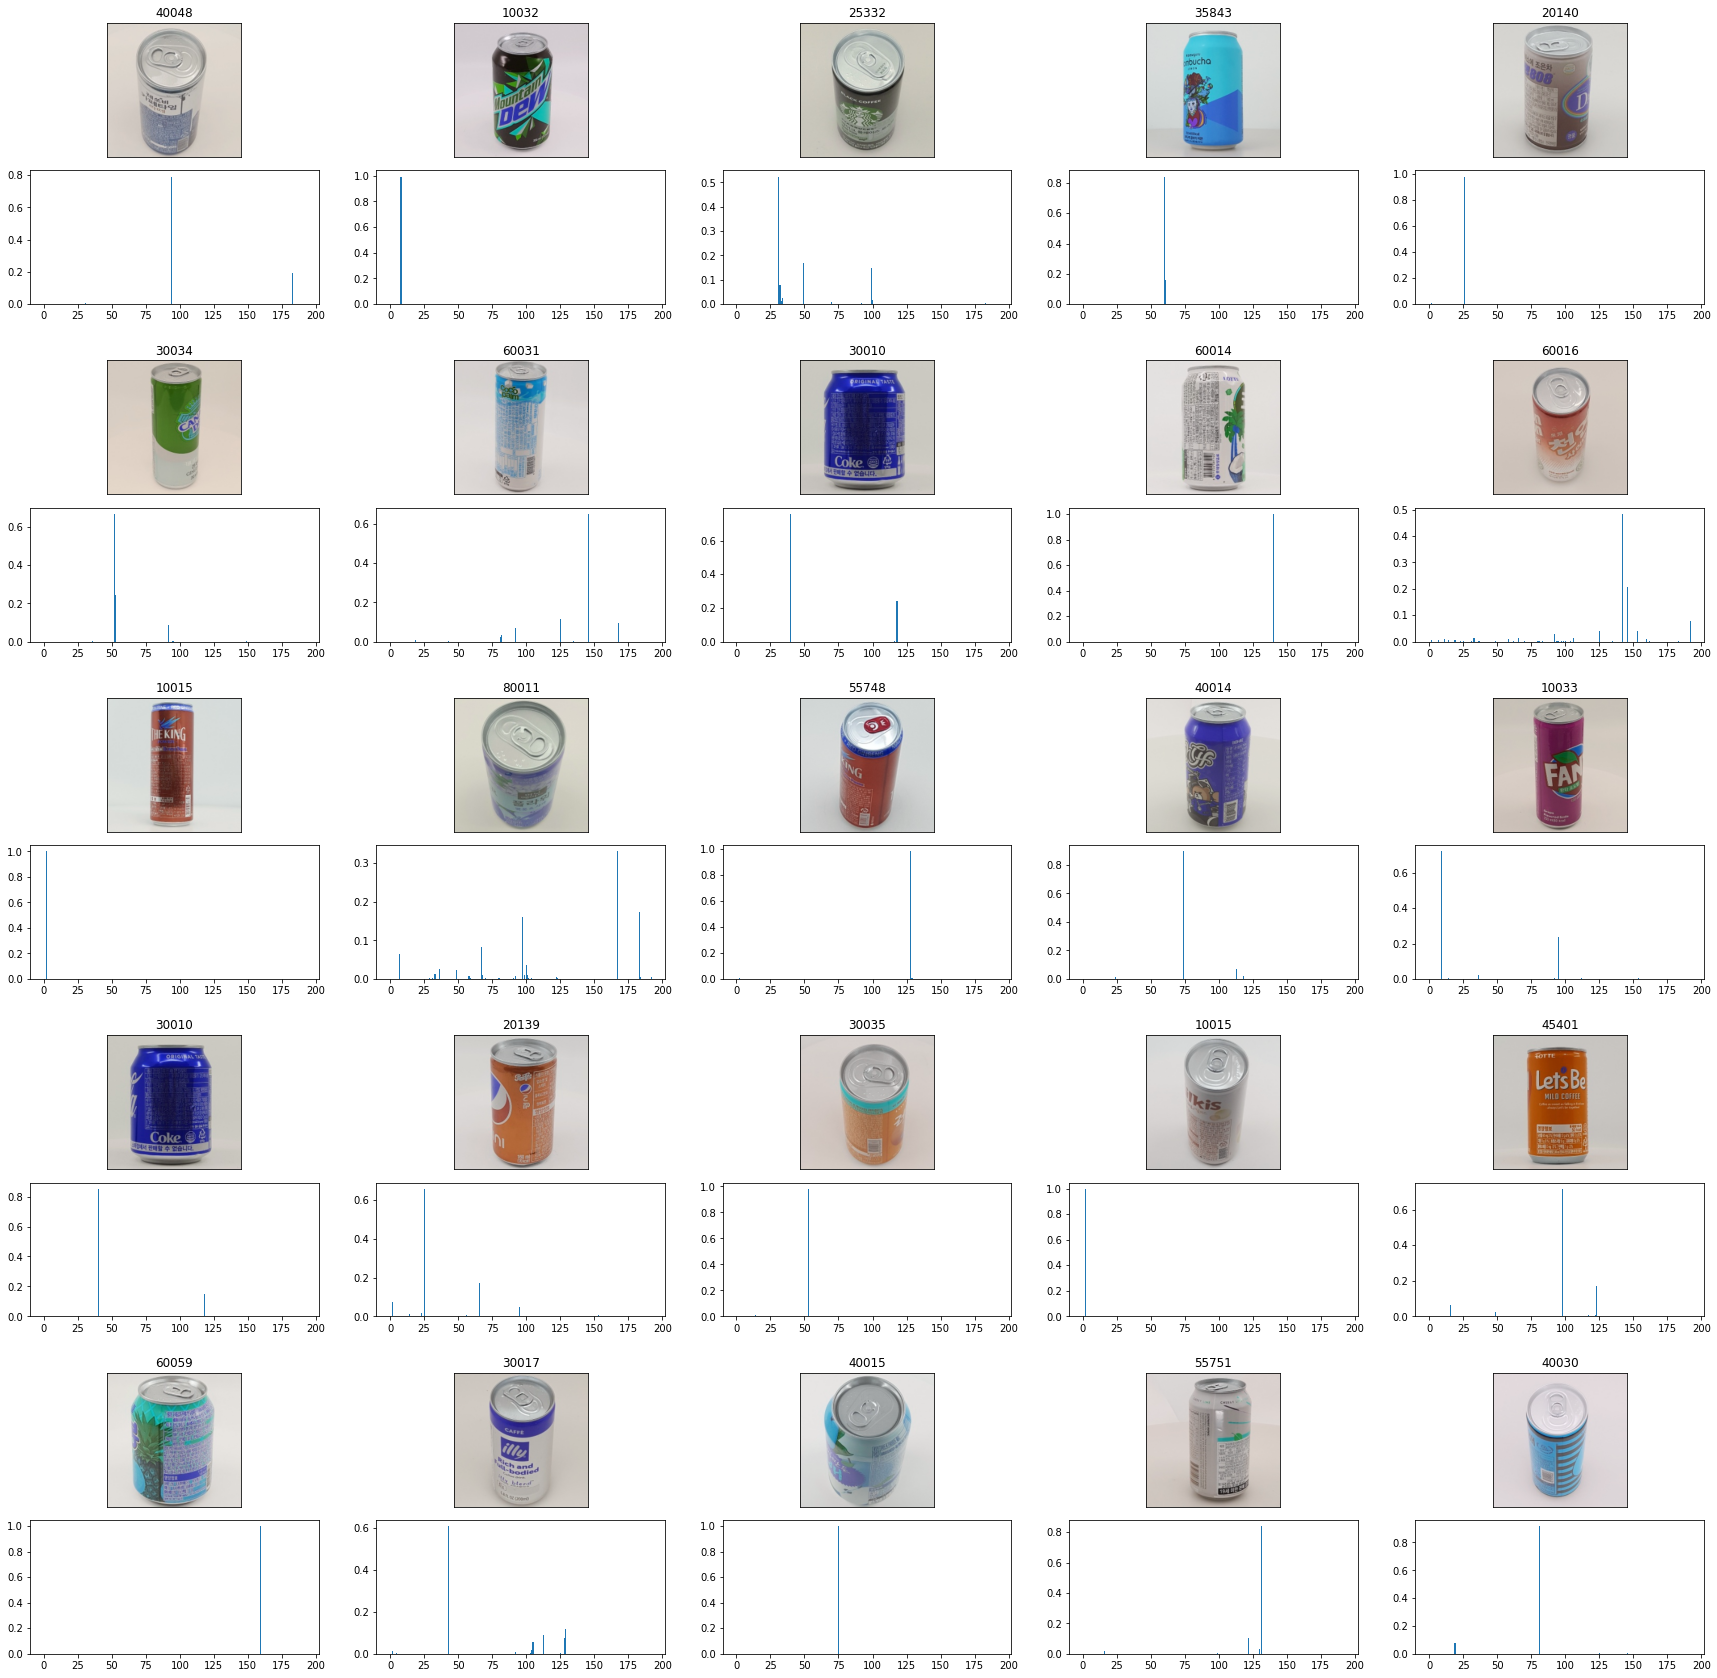

In [ ]:
# 예측한 결과는 아래와 같습니다. 이미지의 위에는 class label을 이미지 아래에는 확률을 나타냅니다.
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(30, 30))
outer = gridspec.GridSpec(5, 5, wspace=0.2, hspace=0.2)

for i in range(25):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    pred_image = np.array([pred_images[i]])

    pred_class = findKey(np.argmax(prediction[i])) 
    pred_prob = prediction[i].reshape(numberOfClass)   # 예측된 결과(확률값)를 1차원 배열(6칸)로 reshape 합니다. 
    for j in range(2):
        if (j%2) == 0:                        # 처음에는 이미지와 title(label name) 을 보여줍니다.
            ax = plt.Subplot(fig, inner[j])
            fix_img = cv2.cvtColor(pred_image[0], cv2.COLOR_BGR2RGB)
            ax.imshow(fix_img)  
            ax.set_title(pred_class)
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)
        else:                                 # 그다음은 확률값을 그래프 형태로 보여줍니다. 
            ax = plt.Subplot(fig, inner[j])
            ax.bar(range(numberOfClass),pred_prob)
            fig.add_subplot(ax)

fig.show()
#왜 label 이 안보일까...
#https://matplotlib.org/3.1.1/gallery/subplots_axes_and_figures/demo_constrained_layout.html#sphx-glr-gallery-subplots-axes-and-figures-demo-constrained-layout-py


In [ ]:
 '/content/drive/MyDrive/안봐도보이조_project/resize_valid_(256,256)/40003/40003_4.jpg'.split('/')[-2]

'40003'

In [ ]:
  #predict  
  pred_images = get25img(test_path)
  pred_images = np.array(pred_images)
  prediction = model.predict(pred_images, verbose = 1)


1/1 [==============================] - 0s 18ms/step


In [ ]:
def compare_pred(directory, num):
  path = glob(directory + "/*/*")
  random_path = random.sample(path, 25)
  out = []
  for i in random_path:
    image = cv2.imread(i)
    image = cv2.resize(image,(224,224))  
    image = np.array(image)
    image = image.reshape(1, 224,224,3)
    prediction =model.predict(image)
    max = np.argmax(prediction)

    answer= i.split('/')[-2]
    pkey = findKey(max) 
    aname= findname2(answer)
    pname = findname(max)
    out.append([answer, pkey,aname, pname])
  out = pd.DataFrame(out, columns = ['answer', 'predict', 'a-name', 'p-name'])
  out['compare'] = np.where(out.answer == out.predict, 1, 0)
  return out


In [ ]:
i = '/content/drive/MyDrive/안봐도보이조_project/resize_valid_(256,256)/40003/40003_4.jpg'
image = cv2.imread(i)
image = cv2.resize(image,(128,128)) 
image = np.array(image) 
image = image.reshape(1, 128,128,3)
predict =model.predict(image)
predict
np.argmax(predict)


102

In [ ]:
findKey(102)

'45501'

In [ ]:
findname(102)

'금강B'

In [ ]:
df = compare_pred(test_path, 20)
df


,answer,predict,a-name,p-name,compare
0,60039,10020,일화)맥콜190ML,일화헛개꿀물175ML,0
1,60011,60011,롯데사각사각수박(캔)340ML,롯데사각사각수박(캔)340ML,1
2,45402,45402,롯데쇼핑)스파클링사이다,롯데쇼핑)스파클링사이다,1
3,60060,60060,코카콜라단짠커피240ML,코카콜라단짠커피240ML,1
4,50016,50028,롯데쌕쌕제주감귤캔180ML,코카)미닛메이드조이오렌지175ML,0
5,60032,60032,일화초정공장벡셀에너지드링크지파크250ML,일화초정공장벡셀에너지드링크지파크250ML,1
6,10052,60031,코카환타오렌지215ML,광동)비타500스파클링(캔),0
7,60020,60016,롯데)유어스도라지꿀배340ML,롯데칠성요랄라요구르트스파클링(캔)340ML,0
8,90003,60016,롯데)쌕쌕오렌지238ML,롯데칠성요랄라요구르트스파클링(캔)340ML,0
9,60012,20139,빅토리아(레몬)350ML,광동제약)비타500,0


In [ ]:
#accuracy from the table
df['compare'].sum()/len(df)

0.52

# prediction

from local computer:
  시각화
  confusion matrix

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('./VGG16_1.h5')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# np.set_printoptions(precision=2)

Y_pred = model.predict(test_data)
classes = test_data.classes[test_data.index_array]
y_pred = np.argmax(Y_pred, axis=1)  # Returns maximum indices in each row

class_names = ['갈아만든배', '레쓰비', '마운틴듀', '밀키스', '스프라이트', '칠성사이다', '코카콜라', '트로피카나망고', '펩시콜라', '환타오렌지'] 

print('-- Confusion Matrix --')
print(confusion_matrix(classes, y_pred))



print('-- Classification Report --')
print(classification_report(classes, y_pred, target_names=class_names))

In [ ]:
import seaborn as sns
plt.figure(figsize=(12,10))
sns.heatmap(confusion_matrix(classes, y_pred), annot=True, fmt='d',
            xticklabels=['갈아만든배','레쓰비','마운틴듀','밀키스','스프라이트','칠성사이다','코카콜라','트로피카나망고','펩시콜라','환타오렌지'],
            yticklabels=['갈아만든배','레쓰비','마운틴듀','밀키스','스프라이트','칠성사이다','코카콜라','트로피카나망고','펩시콜라','환타오렌지'])
# 코랩에서 한글 도저히 안나오는듯
# 뒤에부분은 로컬에서 주피터로 진행해서 히트맵뽑기